In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch as t
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2 
from model import EfficientnetWithFinetuning
from data import MelanomaData
import os
import numpy as np
from melanoma_main import balance_and_shuffle
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
plt.style.use('dark_background')
os.environ["CUDA_VISIBLE_DEVICES"]="1"

2023-11-21 11:33:47.485242: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-21 11:33:47.487870: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-21 11:33:47.523628: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 11:33:48.112390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
markers = ['ADAM10', 'Bcl-2', 'CD10', 'CD107a', 'CD13', 'CD138', 'CD14', 'CD1a', 'CD2', 'CD25', 'CD271', 'CD3', 'CD36', 'CD4', 'CD44', 'CD45', 'CD45RA', 'CD45RO', 'CD5', 'CD56', 'CD6', 'CD63', 'CD66abce', 'CD7', 'CD71', 'CD8', 'CD9', 'CD95', 'Collagen IV', 'Cytokeratin-14', 'EBF-P', 'EGFR', 'EGFR-AF488', 'HLA-ABC', 'HLA-DR', 'KIP1', 'Ki67', 'L302', 'MCSP', 'Melan-A', 'Nestin-AF488', 'Notch-1', 'Notch-3', 'PPARgamma', 'PPB', 'RIM3', 'TAP73', 'Vimentin', 'p63', 'phospho-Connexin']    

In [4]:
model = EfficientnetWithFinetuning(indim=len(markers))
model.load_state_dict(t.load("/data_nfs/je30bery/melanoma_data/model/saved_models/model_2023-11-20 16:27:56.558630_f1=0.9260606060606061_acc=0.9166666666666666_11.pt"))
model.eval()

EfficientnetWithFinetuning(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(50, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): 

In [5]:
data = "/data_nfs/datasets/melc/melanoma/processed"

In [6]:
vdata = sorted([os.path.join(data, "validation", d) for d in sorted(os.listdir(os.path.join(data, "validation")))] + [os.path.join(data, "training", d) for d in sorted(os.listdir(os.path.join(data, "training")))]) # balance_and_shuffle(os.path.join(data, "validation"))#
vdl = t.utils.data.DataLoader(MelanomaData(markers, vdata, mode="val"), batch_size=10) #, shuffle=True)
it = iter(vdl)

In [7]:
target_layers = [model.features[0]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

In [8]:
visualizations = list()
labels = list()
preds = list()
gr_cam = None
done = False
i = 0
while True:
    try:
        input_t, label = next(it)
    except StopIteration:
        break
    grayscale_cam = cam(input_tensor=input_t)        
    ypred = model(input_t.cuda()).detach().cpu().numpy() > 0.5

    for idx in range(len(label)):
        try:
            prop = [p.decode('utf-8') for p in os.listdir(vdata[i]) if "propidium" in str(p).lower()][0]
        except:
            prop = [p for p in os.listdir(vdata[i]) if "propidium" in str(p).lower()][0]
        if prop != None:
            prop_iod = cv2.imread(os.path.join(vdata[i], "bleach", prop))
            prop_iod = prop_iod / np.max(prop_iod)
            prop_iod = cv2.resize(prop_iod, (512, 512)) 
            # In this example grayscale_cam has only one image in the batch:
            visualization = show_cam_on_image(prop_iod, grayscale_cam[idx], use_rgb=True)
            visualizations.append(visualization)
            labels.append(label[idx])
            preds.append(ypred[idx])
        i += 1

In [9]:
if 0:
    h, w = 13, 3
    f, axs = plt.subplots(h, w, figsize=(15, 50))
    for idx in range(len(vdata)):
        axs[idx % h, int(idx / h)].imshow(visualizations[idx])
        title = os.path.basename(vdata[idx]) #"Melanoma" if labels[idx] == 0 else "Nevi"
        axs[idx % h, int(idx / h)].set_title(title)
        axs[idx % h, int(idx / h)].axis("off")
    plt.savefig("gradcam_val.pdf")
    plt.show()

In [10]:
roi_data = {
    '202003251552_1': 20974,
    '202004091556_1': 20982,
    '202004091556_4': 20985,
    '202004221438_1': 20990,
    '202004221438_3': 20992,
    '202004221438_4': 20993,
    '202004301203_2': 20998,
    '202004301203_4': 21000,
    '202005071402_4': 21010,
    '202007020851_4': 21047,
    '202007211656_4': 21060,
    '202007281047_3': 21069,
    '202009031055_3': 21087,
    '202009111023_3': 21100,
    '202009181022_1': 21102,
    '202009181022_3': 21104,
    '202010211103_1': 21124,
    '202010211055_2': 21129,
}

In [11]:
path_dict = dict()
for roi in roi_data:
    print(roi)
    path = [p for p in vdata if roi in p]
    print(path)
    assert len(path) == 1
    path = path[0]
    idx = vdata.index(path)
    roi_path = f"/data_nfs/je30bery/melanoma_data/ROI/{roi_data[roi]}MelanomaArea.tif"
    path_dict[idx] = roi_path 

202003251552_1
['/data_nfs/datasets/melc/melanoma/processed/training/Melanoma_23_202003251552_1']
202004091556_1
['/data_nfs/datasets/melc/melanoma/processed/training/Melanoma_25_202004091556_1']
202004091556_4
['/data_nfs/datasets/melc/melanoma/processed/training/Melanoma_25_202004091556_4']
202004221438_1
['/data_nfs/datasets/melc/melanoma/processed/training/Melanoma_26_202004221438_1']
202004221438_3
['/data_nfs/datasets/melc/melanoma/processed/training/Melanoma_26_202004221438_3']
202004221438_4
['/data_nfs/datasets/melc/melanoma/processed/training/Melanoma_26_202004221438_4']
202004301203_2
['/data_nfs/datasets/melc/melanoma/processed/training/Melanoma_27_202004301203_2']
202004301203_4
['/data_nfs/datasets/melc/melanoma/processed/training/Melanoma_27_202004301203_4']
202005071402_4
['/data_nfs/datasets/melc/melanoma/processed/training/Melanoma_28_202005071402_4']
202007020851_4
['/data_nfs/datasets/melc/melanoma/processed/validation/Melanoma_30_202007020851_4']
202007211656_4
['/

In [12]:
len(path_dict)

18

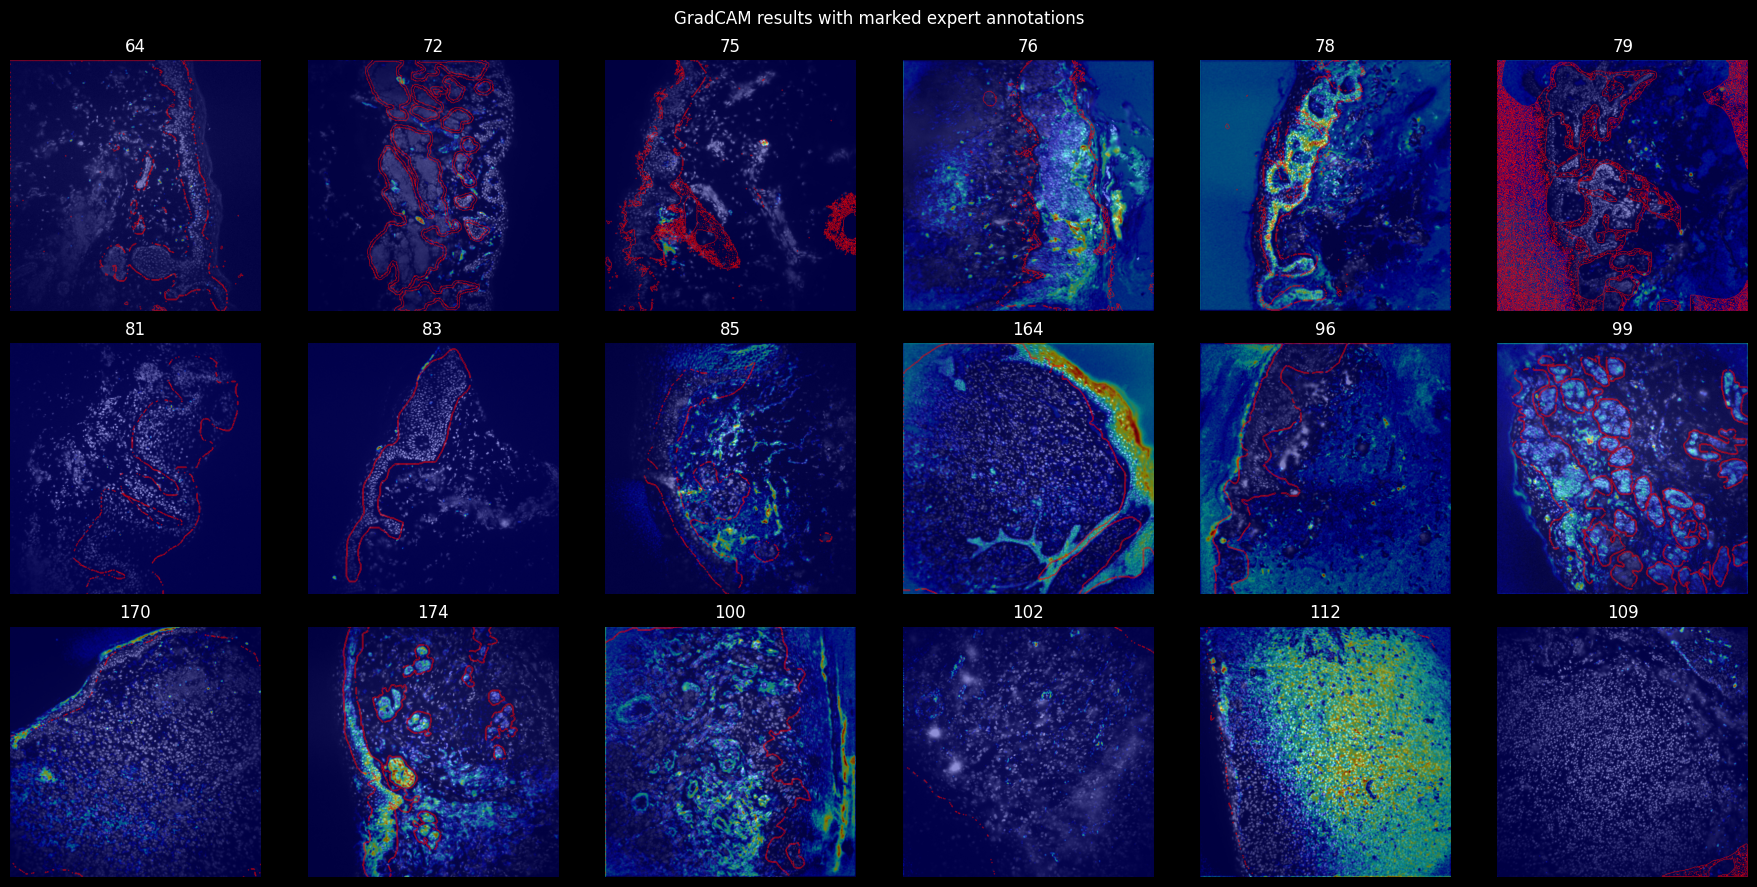

In [24]:
f, axs = plt.subplots(3, 6, figsize=(18,9))
for i, k in enumerate(path_dict):
    boundaries = cv2.resize((cv2.imread(path_dict[k], cv2.IMREAD_GRAYSCALE) > 0).astype(np.uint8), (512,512))
    axs[int(i/6), i%6].imshow(mark_boundaries(visualizations[k], boundaries, color=(1,0,0)))
    axs[int(i/6), i%6].axis("off")
    axs[int(i/6), i%6].set_title(k)
plt.suptitle("GradCAM results with marked expert annotations")
plt.tight_layout()
plt.savefig("gradcam_val.pdf")

In [26]:
grayscale_cam.shape

(7, 512, 512)